<a href="https://colab.research.google.com/github/nitron-alpha-kplr/Generative-IA/blob/main/cgan_leger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤪 Conditional GAN trained on CelebA Faces dataset


> ### **!!! Attention :**

> #### **Avant de commencer le workshop, uploader les fichiers joignants au notebook dans le repository github "Generative IA"**


* Dans ce workshop, nous conditionnerons notre CGAN sur l'attribut des cheveux blonds de l'ensemble de données de visages.

* C'est-à-dire que nous serons en mesure de spécifier explicitement si nous voulons générer une image avec des cheveux blonds ou non.

* Cette étiquette est fournie dans le cadre de l'ensemble de données CelebA.

* L'architecture de notre CGAN peut etre présenter comme suit :

* 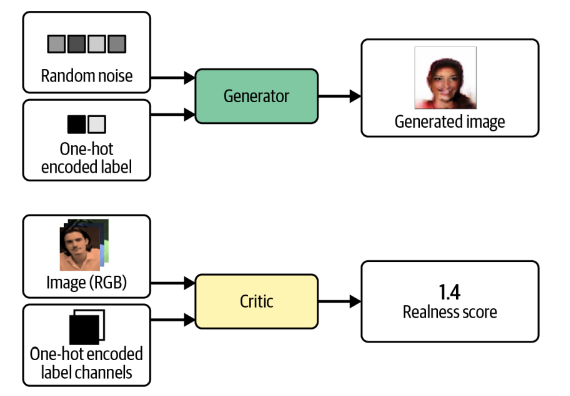

* La principale différence entre un GAN standard et un CGAN réside dans le fait qu'avec un CGAN, nous transmettons des informations supplémentaires au générateur.


In [11]:
# l'importation des différentes librairies
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    optimizers,
)

from utils import display, sample_batch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Parameters <a name="parameters"></a>

In [12]:
# Configuration des paramètres pour l'entraînement
IMAGE_SIZE = 64
CHANNELS = 3
CLASSES = 2
BATCH_SIZE = 128
Z_DIM = 32
LEARNING_RATE = 0.00005
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 20
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
LABEL = "Blond_Hair"

## 1. Prepare the data <a name="prepare"></a>

In [13]:
# Chargez l'ensemble de données d'étiquettes.
attributes = pd.read_csv("list_attr_celeba.csv")
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0


In [14]:
# Chargez l'ensemble de données.
labels = attributes[LABEL].tolist()
int_labels = [x if x == 1 else 0 for x in labels]

In [15]:
# Installer l'API Kaggle
!pip install -q kaggle

# Télécharger le fichier kaggle.json et le mettre dans le répertoire approprié
from google.colab import files
files.upload() # Téléchargez le fichier kaggle.json ici
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Télécharger le dataset img_align_celeba
!kaggle datasets download -d jessicali9530/celeba-dataset


Saving list_attr_celeba.csv to list_attr_celeba (1).csv
celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q  /content/celeba-dataset.zip -d /content/celebA

replace /content/celebA/img_align_celeba/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# préparer et charger les données d'entraînement du modèle.
train_data = utils.image_dataset_from_directory(
    "/content/celebA/img_align_celeba/img_align_celebA",
    labels=int_labels,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

In [ ]:
# Ne prendre que les 59679 premières images et leurs étiquettes
selected_filenames = image_filenames[:59679]
selected_labels = int_labels[:59679]

In [ ]:
import os
import shutil
from tensorflow.keras import utils

# Définir le chemin du répertoire des images
image_directory = "/content/celebA/img_align_celeba/img_align_celeba"

# Créer un sous-répertoire pour les 59679 premières images
selected_directory = "/content/selected_images"
os.makedirs(selected_directory, exist_ok=True)

# Obtenir la liste des noms de fichiers des images
image_filenames = os.listdir(image_directory)

# Trier la liste des noms de fichiers
image_filenames.sort()

# Copier les 59679 premières images dans le sous-répertoire
for filename in image_filenames[:59679]:
    src_path = os.path.join(image_directory, filename)
    dst_path = os.path.join(selected_directory, filename)
    shutil.copy(src_path, dst_path)

# Charger les données d'entraînement depuis le sous-répertoire
train_data = utils.image_dataset_from_directory(
    selected_directory,
    labels=selected_labels[:59679],
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)


In [ ]:
# Définition d'une fonction de prétraitement pour normaliser et remodeler les images.

def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img

# Application de la fonction de prétraitement aux données d'entraînement.
# Cela normalise et prépare les images pour l'entraînement du modèle.
train = train_data.map(
    lambda x, y: (preprocess(x), tf.one_hot(y, depth=CLASSES))
)

In [ ]:
# Affichez quelques visages de l'ensemble d'entraînement.
train_sample = sample_batch(train)

In [ ]:
display(train_sample, cmap=None)

## 2. Build the GAN <a name="build"></a>

* La seule modification que nous devons apporter à l'architecture consiste à concaténer les informations d'étiquette aux entrées existantes du générateur et du discriminateur.


In [ ]:
# Les canaux d'images et les canaux d'étiquettes sont transmis séparément au discriminateur et concaténés.

critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
label_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CLASSES))
x = layers.Concatenate(axis=-1)([critic_input, label_input])
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model([critic_input, label_input], critic_output)
critic.summary()

In [ ]:
# Le vecteur latent et les classes d'étiquettes sont transmis séparément au générateur et concaténés avant d'être remodelés.
generator_input = layers.Input(shape=(Z_DIM,))
label_input = layers.Input(shape=(CLASSES,))
x = layers.Concatenate(axis=-1)([generator_input, label_input])
x = layers.Reshape((1, 1, Z_DIM + CLASSES))(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh"
)(x)
generator = models.Model([generator_input, label_input], generator_output)
generator.summary()

* Nous devons également apporter quelques modifications à la méthode train_step du CGAN pour correspondre aux nouveaux formats d'entrée du générateur et du discriminateur.

In [ ]:
class ConditionalWGAN(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(ConditionalWGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(ConditionalWGAN, self).compile(run_eagerly=True)
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(
        self, batch_size, real_images, fake_images, image_one_hot_labels
    ):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(
                [interpolated, image_one_hot_labels], training=True
            )

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_images, one_hot_labels = data # Les images et les étiquettes sont extraites des données d'entrée.

        image_one_hot_labels = one_hot_labels[:, None, None, :] # Les vecteurs codés en one-hot sont étendus pour créer des images codées en one-hot ayant la même taille spatiale que les images d'entrée (64 × 64).
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=IMAGE_SIZE, axis=1
        )
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=IMAGE_SIZE, axis=2
        )

        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    [random_latent_vectors, one_hot_labels], training=True
                ) # Le générateur est désormais alimenté par une liste de deux entrées : les vecteurs latents aléatoires et les vecteurs d'étiquettes codées en one-hot.

                fake_predictions = self.critic(
                    [fake_images, image_one_hot_labels], training=True
                ) # Le discriminateur reçoit également une liste de deux entrées : les images fake/réelles et les canaux d'étiquettes codées en one-hot.
                real_predictions = self.critic(
                    [real_images, image_one_hot_labels], training=True
                )

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images, image_one_hot_labels
                ) # La fonction de pénalité de gradient nécessite également que les canaux d'étiquettes codées en one-hot soient transmis, car elle utilise le discriminateur.
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        with tf.GradientTape() as tape:
            fake_images = self.generator(
                [random_latent_vectors, one_hot_labels], training=True
            ) # Les modifications apportées à l'étape d'entraînement du discriminateur s'appliquent également à l'étape d'entraînement du générateur.
            fake_predictions = self.critic(
                [fake_images, image_one_hot_labels], training=True
            )
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [ ]:
# Création de CGAN
cgan = ConditionalWGAN(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [ ]:
# Vérification de la condition LOAD_MODEL pour décider si le modèle doit être chargé depuis un point de contrôle.

if LOAD_MODEL:
    #  Charge les poids d'un modèle préalablement sauvegardé depuis le chemin spécifié.
    cgan.load_weights("./checkpoint/checkpoint.ckpt")

## 3. Train the GAN <a name="train"></a>

In [ ]:
# Compiler le GAN
cgan.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [ ]:
# Définition de deux callbacks pour surveiller et enregistrer le modèle pendant l'entraînement.
# ModelCheckpoint est un callback qui permet de sauvegarder les poids du modèle à intervalles spécifiques.

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

# TensorBoard est un callback qui permet de créer des journaux pour visualiser l'entraînement du modèle.

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Définition d'une classe de callback personnalisée, ImageGenerator, pour générer des images pendant l'entraînement du modèle.

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        # Initialise la classe avec le nombre d'images à générer et la dimension latente du modèle.

        self.num_img = num_img
        self.latent_dim = latent_dim

    # Cette méthode est appelée à la fin de chaque époque d'entraînement pour génèrer des vecteurs de bruit aléatoires dans l'espace latent du modèle.
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        # 0 label
        zero_label = np.repeat([[1, 0]], self.num_img, axis=0)
        generated_images = self.model.generator(
            [random_latent_vectors, zero_label]
        )
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d_label_0.png" % (epoch),
            cmap=None,
        )

        # 1 label
        one_label = np.repeat([[0, 1]], self.num_img, axis=0)
        generated_images = self.model.generator(
            [random_latent_vectors, one_label]
        )
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d_label_1.png" %(epoch),
            cmap=None,
        )

In [ ]:
# Créer le dossier 'output' s'il n'existe pas
if not os.path.exists('./output'):
    os.makedirs('./output')

# Lancement de l'entraînement du modèle CGAN avec des paramètres spécifiques et des callbacks.
history = cgan.fit(
    train,
    epochs=EPOCHS * 100,
    steps_per_epoch=1,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)


In [ ]:
# Lancement de l'entraînement du modèle CGAN avec des paramètres spécifiques et des callbacks.

history = cgan.fit(
    train,
    epochs=EPOCHS * 100,
    steps_per_epoch=1,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [ ]:
# Sauvegarder les modèles
generator.save("./models/generator")
critic.save("./models/critic")

## Generate images

In [ ]:
# Génération et affichage d'images à l'aide du modèle générateur du CGAN.

# 0 label
z_sample = np.random.normal(size=(10, Z_DIM))
class_label = np.repeat([[1, 0]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)

In [ ]:
# Génération et affichage d'un autre ensemble de 10 images en utilisant le modèle générateur du CGAN.

# 1 label
z_sample = np.random.normal(size=(10, Z_DIM))
class_label = np.repeat([[0, 1]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)